In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque, defaultdict

**Belady's OPT**

In [2]:
# function to find the next block to be evicted for OPT policy

def find_farthest(cache, rem_accesses):
  farthest = -1
  idx_dict = {}

  for blk in cache:
    if blk not in rem_accesses:
      farthest = blk
      return farthest

    else:
      idx_dict[blk] = rem_accesses.index(blk)
    
  srt_dict = sorted(idx_dict.items(), key = lambda item: item[1], reverse = True)

  return srt_dict[0][0]
  

In [3]:
#Offline OPT replacement policy implementation

def OPT(accesses,size):
  cache = set()
  hits = 0
  misses = 0
  isFull = False
  
  for i,blk in enumerate(accesses):

    if blk in cache:
      hits += 1
      
    else:
      misses +=1

      if (isFull == False):
        cache.add(blk)
        if(len(cache) == size):
          isFull = True
      else:
        farthest = find_farthest(cache,accesses[i+1:])
        cache.remove(farthest)
        cache.add(blk)
    #print(i+1,cache)

  hit_rate = hits/(hits + misses)
  return hit_rate

**LRU**

In [4]:
def LRU(accesses,size) :
  hit = 0
  miss = 0
  cache = set()
  recent_items = deque()

  for item in accesses :
    cur_size = len(cache)
    if item in cache :
      hit = hit + 1
      recent_items.remove(item)
      recent_items.append(item)

    elif cur_size < size :
      miss = miss + 1
      recent_items.append(item)
      cache.add(item)

    else :
      miss = miss + 1
      removed_item = recent_items[0]
      recent_items.popleft()
      cache.remove(removed_item)
      cache.add(item)
      recent_items.append(item)
    #print(cache)

  hit_ratio = hit / (hit+miss)   
  return hit_ratio 


**LFU**

In [5]:
def LFU(accesses,size):

    hit = 0
    miss = 0
    
    freq_cache = defaultdict(int)   #holds the frequency of all elements 
    freq = defaultdict(int)         #holds the frequency of elements present in cache
    
    cache = set()
    
    for block in accesses:
        freq[block] += 1
      
        if block in cache:
            hit += 1
            freq_cache[block] += 1
        
        elif len(cache) < size:
            cache.add(block)
            freq_cache[block] += 1
            miss += 1

        else:
            x, y = min(freq_cache.items(), key=lambda a: a[1])
            freq_cache.pop(x)
            cache.remove(x)
            cache.add(block)
            freq_cache[block] = freq[block]
            miss += 1
        #print(cache)
    hit_rate = hit / ( hit + miss )
    return hit_rate

**DAS**

In [6]:
def DAS(accesses,size):
  # LRU portion and LFU portion..
  LRU_size = (int)(0.8*size)
  LFU_size = size-LRU_size

  # print(LRU_size);
  # print(LFU_size);
  # variables to keep track of hits..
  hits = miss = 0;
  LRU_hit = LFU_hit = 0;

  # LRU and LFU cache..
  LRU_cache = deque();
  LFU_cache = deque();

  # map for storing frequencies..
  LRU_freq = defaultdict(int);
  LFU_freq = defaultdict(int);
  freq = defaultdict(int);

  for block in accesses :
    freq[block] = freq[block]+1;

    if block not in LRU_cache and block not in LFU_cache :
      miss = miss+1;
      # if space is available in cache..
      if (len(LRU_cache)+len(LFU_cache)) < size :
        # checking for LRU..
        if len(LRU_cache) < LRU_size :
          LRU_cache.append(block);
          LRU_freq[block] += 1;
        # checking for LFU..
        elif len(LFU_cache) < LFU_size :
          LFU_cache.append(block);
          LFU_freq[block] += 1;
      # if space is not available in cache..
      else :
        remove_block = LRU_cache.popleft();
        del LRU_freq[remove_block];
        LRU_cache.append(block);
        LRU_freq[block] = freq[block];

    else :
      hits = hits+1;
      # present in LFU cache..
      if block in LFU_cache :
        LFU_freq[block] += 1;
        LFU_hit += 1;
      # present in LRU cache..
      elif block in LRU_cache :
        LRU_freq[block] += 1;
        LRU_hit += 1;
        # we need to check whethe it can be added to LFU or not..
        if len(LFU_cache) < LFU_size :
          LRU_cache.remove(block);
          LFU_freq[block] = LRU_freq[block];
          LFU_cache.append(block);
          del LRU_freq[block];
        else :
          mini,mini_freq = min(LFU_freq.items(),key = lambda a: a[1])
          # if minimum frequency in LFU is less than block's frequency..swap these two..
          if mini_freq < LRU_freq[block] :
            # adding block to LFU..
            LRU_cache.remove(block);
            LFU_cache.append(block);
            LFU_freq[block] = LRU_freq[block];
            del LRU_freq[block];
            # adding mini to LRU..
            LFU_cache.remove(mini);
            LRU_cache.append(mini);
            LRU_freq[mini] = mini_freq;
            del LFU_freq[mini];

  hit_ratio = hits/(hits+miss);
  return hit_ratio;

In [10]:
size = [5,10,15,20,25,30,35,40,45] #cache size

f = open('sort1','r');
accesses = []

for x in f:
  accesses.append(int(x,16));

opt_hit = []
lru_hit = []
lfu_hit = []
das_hit = []

for sz in size:
  opt_hit.append(OPT(accesses,sz)*100)
  lru_hit.append(LRU(accesses,sz)*100)
  lfu_hit.append(LFU(accesses,sz)*100)
  das_hit.append(DAS(accesses,sz)*100)

dict = {'x': size, 'y': opt_hit} 
opt_df = pd.DataFrame(dict)
opt_df.to_csv('sort1_opt.csv')
opt = pd.read_csv('sort1_opt.csv')

dict = {'x': size, 'y': lru_hit} 
lru_df = pd.DataFrame(dict)
lru_df.to_csv('sort1_lru.csv')
lru = pd.read_csv('sort1_lru.csv')

dict = {'x': size, 'y': lfu_hit} 
lfu_df = pd.DataFrame(dict)
lfu_df.to_csv('sort1_lfu.csv')
lfu = pd.read_csv('sort1_lfu.csv')

dict = {'x': size, 'y': das_hit} 
das_df = pd.DataFrame(dict)
das_df.to_csv('sort1_das.csv')
das = pd.read_csv('sort1_das.csv')

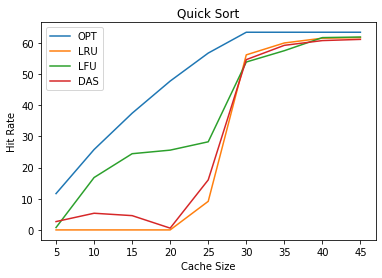

In [11]:
plt.plot(size,opt_hit, label = 'OPT')
plt.plot(size,lru_hit, label = 'LRU')
plt.plot(size,lfu_hit, label = 'LFU')
plt.plot(size,das_hit, label = 'DAS')
plt.legend()
plt.title("Quick Sort")
plt.xlabel("Cache Size")
plt.ylabel("Hit Rate")

plt.show()